<a href="https://colab.research.google.com/github/KillerStrike17/Intro_with_pytorch/blob/master/PyTorch_102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Fri Feb 21 05:37:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
torch.__version__

'1.4.0'

# Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                      #  
                                       
                                      #  transforms.ToTensor()
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                      # transforms.ToPILImage(),
                                       
                                      #  transforms.ToTensor()
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images


plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


TypeError: ignored



It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f64ead4c320>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


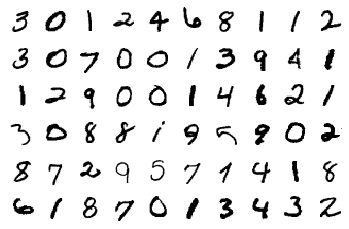

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
This model is ran without applying augemntation of rotation or applying LR. The model was developed to be under 15K parameters with bathc norm and dropout at some places based on intuition.

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=18, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU()
        ) # output_size = 24
        self.batchnormblock1 = nn.Sequential(
            nn.BatchNorm2d(18)
        )
        self.dropoutblock1 = nn.Sequential(
            nn.Dropout(p=0.1)
        )
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=18, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU()
        ) # output_size = 22
        
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU()
        ) # output_size = 11
        # CONVOLUTION BLOCK 2
        self.batchnormblock2 = nn.Sequential(
            nn.BatchNorm2d(10)
        )
        self.dropoutblock2 = nn.Sequential(
            nn.Dropout(p=0.1)
        )
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=18, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=18, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU()
        )
        self.batchnormblock3 = nn.Sequential(
            nn.BatchNorm2d(18)
        )
        self.dropoutblock3 = nn.Sequential(
            nn.Dropout(p=0.1)
        )
        
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU()
        ) 
        # output_size = 7
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=True),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.batchnormblock1(x)
        x = self.dropoutblock1(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.batchnormblock2(x)
        x = self.dropoutblock2(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropoutblock3(x)
        x = self.batchnormblock3(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 18, 24, 24]           1,638
              ReLU-4           [-1, 18, 24, 24]               0
       BatchNorm2d-5           [-1, 18, 24, 24]              36
           Dropout-6           [-1, 18, 24, 24]               0
            Conv2d-7           [-1, 18, 22, 22]           2,934
              ReLU-8           [-1, 18, 22, 22]               0
         MaxPool2d-9           [-1, 18, 11, 11]               0
           Conv2d-10           [-1, 10, 11, 11]             190
             ReLU-11           [-1, 10, 11, 11]               0
      BatchNorm2d-12           [-1, 10, 11, 11]              20
          Dropout-13           [-1, 10, 11, 11]               0
           Conv2d-14             [

## Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer,gamma=0.1,step_size=6)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.05730484053492546 Batch_id=468 Accuracy=92.64: 100%|██████████| 469/469 [00:11<00:00, 41.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0655, Accuracy: 9800/10000 (98.00%)

EPOCH: 1


Loss=0.012181933037936687 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:10<00:00, 43.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9861/10000 (98.61%)

EPOCH: 2


Loss=0.05256812274456024 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:11<00:00, 49.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.05388462543487549 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:10<00:00, 43.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9905/10000 (99.05%)

EPOCH: 4


Loss=0.016845643520355225 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:10<00:00, 43.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9889/10000 (98.89%)

EPOCH: 5


Loss=0.10739826411008835 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:11<00:00, 42.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9892/10000 (98.92%)

EPOCH: 6


Loss=0.004511078353971243 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:10<00:00, 44.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


Loss=0.07134964317083359 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:10<00:00, 43.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.03246079757809639 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:10<00:00, 44.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.0020099978428333998 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:10<00:00, 43.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9894/10000 (98.94%)

EPOCH: 10


Loss=0.013718445785343647 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:11<00:00, 42.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.005868181586265564 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:10<00:00, 51.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9910/10000 (99.10%)

EPOCH: 12


Loss=0.026627495884895325 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:10<00:00, 44.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9919/10000 (99.19%)

EPOCH: 13


Loss=0.007979611866176128 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:10<00:00, 50.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.005670244339853525 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:10<00:00, 52.50it/s]



Test set: Average loss: 0.0268, Accuracy: 9919/10000 (99.19%)



Text(0.5, 1.0, 'Test Accuracy')

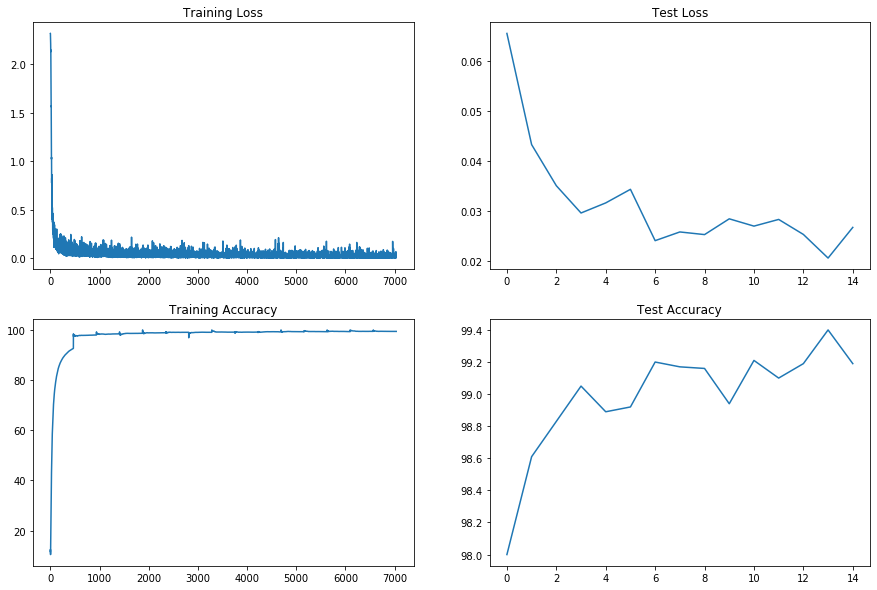

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Analysis

From viewing the logs generated by the model and the graphs generated, it can be inferred that the accuracy and loss is not stable, hence we cant wait for a mircale epoch to turn things for us

# The model 2

The model is tweaked with augmentation stratergies like Random Rotation

In [0]:
class Net(nn.Module):
  
    def __init__(self):

        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=18, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU()
        )

        self.batchnormblock1 = nn.Sequential(
            nn.BatchNorm2d(18)
        )
        self.dropoutblock1 = nn.Sequential(
            nn.Dropout(p=0.1)
        )
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=18, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU()
        )
        
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2)

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU()
        )
        # CONVOLUTION BLOCK 2
        self.batchnormblock2 = nn.Sequential(
            nn.BatchNorm2d(10)
        )
        self.dropoutblock2 = nn.Sequential(
            nn.Dropout(p=0.1)
        )
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=18, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU()
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=18, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU()
        )
        self.batchnormblock3 = nn.Sequential(
            nn.BatchNorm2d(18)
        )
        self.dropoutblock3 = nn.Sequential(
            nn.Dropout(p=0.1)
        )
        
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU()
        ) 
        # output_size = 7
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=True),
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.batchnormblock1(x)
        x = self.dropoutblock1(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.batchnormblock2(x)
        x = self.dropoutblock2(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropoutblock3(x)
        x = self.batchnormblock3(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 18, 24, 24]           1,638
              ReLU-4           [-1, 18, 24, 24]               0
       BatchNorm2d-5           [-1, 18, 24, 24]              36
           Dropout-6           [-1, 18, 24, 24]               0
            Conv2d-7           [-1, 18, 22, 22]           2,934
              ReLU-8           [-1, 18, 22, 22]               0
         MaxPool2d-9           [-1, 18, 11, 11]               0
           Conv2d-10           [-1, 10, 11, 11]             190
             ReLU-11           [-1, 10, 11, 11]               0
      BatchNorm2d-12           [-1, 10, 11, 11]              20
          Dropout-13           [-1, 10, 11, 11]               0
           Conv2d-14             [

## Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer,gamma=0.1,step_size=6)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.11874634772539139 Batch_id=468 Accuracy=91.16: 100%|██████████| 469/469 [00:18<00:00, 24.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0658, Accuracy: 9809/10000 (98.09%)

EPOCH: 1


Loss=0.15613903105258942 Batch_id=468 Accuracy=97.13: 100%|██████████| 469/469 [00:18<00:00, 25.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9837/10000 (98.37%)

EPOCH: 2


Loss=0.03889657184481621 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:18<00:00, 24.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


Loss=0.11035075783729553 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:19<00:00, 24.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9897/10000 (98.97%)

EPOCH: 4


Loss=0.03203466907143593 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:19<00:00, 24.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9906/10000 (99.06%)

EPOCH: 5


Loss=0.0682704746723175 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:19<00:00, 24.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.052778515964746475 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:19<00:00, 24.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.055597931146621704 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:19<00:00, 24.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.14301219582557678 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:19<00:00, 24.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.006072560790926218 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:19<00:00, 24.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.11570797115564346 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:19<00:00, 24.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9914/10000 (99.14%)

EPOCH: 11


Loss=0.033349502831697464 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:19<00:00, 23.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9911/10000 (99.11%)

EPOCH: 12


Loss=0.04672063887119293 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:19<00:00, 24.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.05074784532189369 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:20<00:00, 23.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

EPOCH: 14


Loss=0.022466987371444702 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:19<00:00, 23.84it/s]



Test set: Average loss: 0.0182, Accuracy: 9943/10000 (99.43%)



Text(0.5, 1.0, 'Test Accuracy')

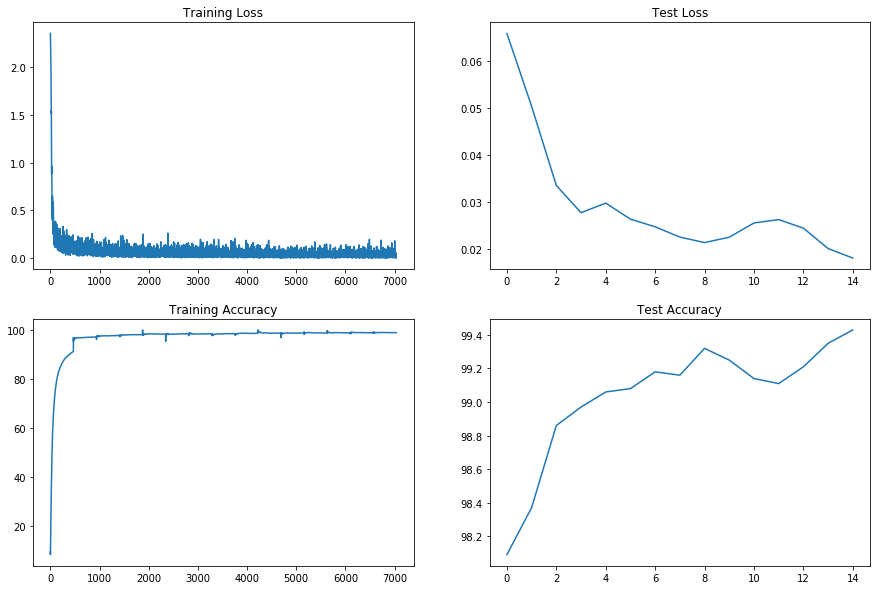

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Analysis


By looking at the graphs and logs, I infer that we have a bit of consistency in the model 

# The model 3
Step LR is added to the code 

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.1)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=18, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout(0.1)

        ) # output_size = 24

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=18, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout(0.1)
        ) # output_size = 22
        
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU()
        ) # output_size = 11
        # CONVOLUTION BLOCK 2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=18, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout(0.1)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=18, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout(0.1)
        )

        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU()
        ) 
        # output_size = 7
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=True),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)

        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)

        x = self.convblock5(x)
        x = self.convblock6(x)

        x = self.convblock8(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 18, 24, 24]           1,638
              ReLU-6           [-1, 18, 24, 24]               0
       BatchNorm2d-7           [-1, 18, 24, 24]              36
           Dropout-8           [-1, 18, 24, 24]               0
            Conv2d-9           [-1, 18, 22, 22]           2,934
             ReLU-10           [-1, 18, 22, 22]               0
      BatchNorm2d-11           [-1, 18, 22, 22]              36
          Dropout-12           [-1, 18, 22, 22]               0
        MaxPool2d-13           [-1, 18, 11, 11]               0
           Conv2d-14           [-1

## Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer,gamma=0.1,step_size=6)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.09436037391424179 Batch_id=468 Accuracy=91.41: 100%|██████████| 469/469 [00:19<00:00, 24.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Accuracy: 9837/10000 (98.37%)

EPOCH: 1


Loss=0.17393915355205536 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:19<00:00, 24.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9875/10000 (98.75%)

EPOCH: 2


Loss=0.09772754460573196 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:19<00:00, 24.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9878/10000 (98.78%)

EPOCH: 3


Loss=0.060709793120622635 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:19<00:00, 24.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9894/10000 (98.94%)

EPOCH: 4


Loss=0.12719346582889557 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:19<00:00, 24.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Loss=0.013908743858337402 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:19<00:00, 23.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9896/10000 (98.96%)

EPOCH: 6


Loss=0.057729169726371765 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:19<00:00, 27.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9929/10000 (99.29%)

EPOCH: 7


Loss=0.029023224487900734 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:19<00:00, 24.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9931/10000 (99.31%)

EPOCH: 8


Loss=0.010516869835555553 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:19<00:00, 23.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)

EPOCH: 9


Loss=0.007884860038757324 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:19<00:00, 23.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.08073116093873978 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:19<00:00, 23.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.06637439876794815 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:19<00:00, 23.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.03661200404167175 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:19<00:00, 24.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


Loss=0.0283962432295084 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:19<00:00, 28.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.025464624166488647 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:19<00:00, 23.82it/s]



Test set: Average loss: 0.0202, Accuracy: 9939/10000 (99.39%)



Text(0.5, 1.0, 'Test Accuracy')

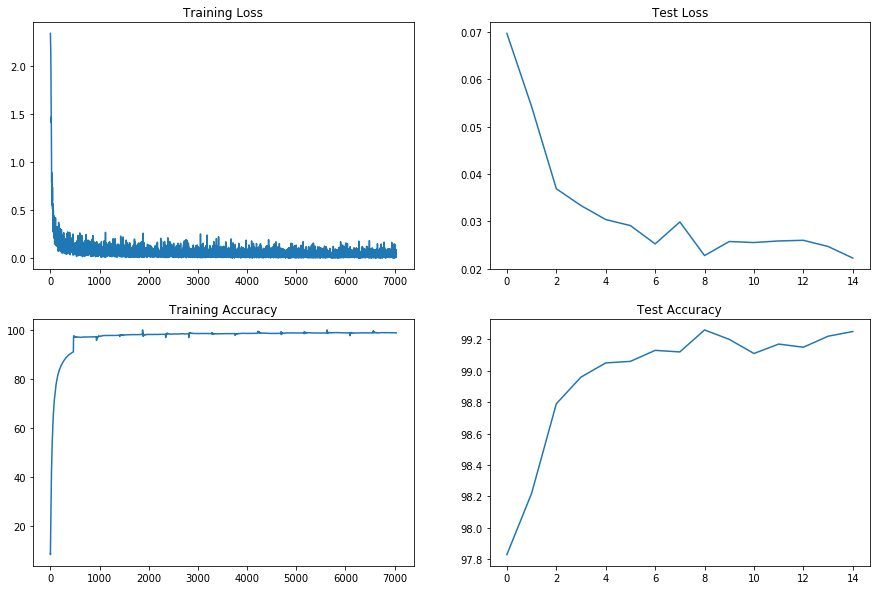

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Analysis

By adding LR and Augmentation, we get a more smother curve, That means the model is becoming more and more replicatable

# The model 4
The model is being tweaked to reduce the parameter under 10k and a bit of hyper parameter tuning is done

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.1)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=18, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout(0.1)

        ) # output_size = 24

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=18, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout(0.1)
        ) # output_size = 22
        
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU()
        ) # output_size = 11
        # CONVOLUTION BLOCK 2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=18, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout(0.1)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=18, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout(0.1)
        )
        self.gap = nn.Sequential(
            nn.AvgPool2d(7)
        )
        
        # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=10, kernel_size=(1, 1), padding=0, bias=True),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)

        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)

        x = self.convblock5(x)
        x = self.convblock6(x)

        x = self.gap(x)
        x = self.convblock8(x)
        # x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 18, 24, 24]           1,638
              ReLU-6           [-1, 18, 24, 24]               0
       BatchNorm2d-7           [-1, 18, 24, 24]              36
           Dropout-8           [-1, 18, 24, 24]               0
            Conv2d-9           [-1, 18, 22, 22]           2,934
             ReLU-10           [-1, 18, 22, 22]               0
      BatchNorm2d-11           [-1, 18, 22, 22]              36
          Dropout-12           [-1, 18, 22, 22]               0
        MaxPool2d-13           [-1, 18, 11, 11]               0
           Conv2d-14           [-1

## Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer,gamma=0.1,step_size=6)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.10103348642587662 Batch_id=468 Accuracy=90.69: 100%|██████████| 469/469 [00:20<00:00, 23.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0640, Accuracy: 9792/10000 (97.92%)

EPOCH: 1


Loss=0.04638288915157318 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:19<00:00, 27.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9834/10000 (98.34%)

EPOCH: 2


Loss=0.07768937200307846 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:19<00:00, 24.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9863/10000 (98.63%)

EPOCH: 3


Loss=0.03710073605179787 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:19<00:00, 23.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0566, Accuracy: 9822/10000 (98.22%)

EPOCH: 4


Loss=0.11241837590932846 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:19<00:00, 23.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Loss=0.0893682911992073 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:19<00:00, 23.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.08434443920850754 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:19<00:00, 23.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9932/10000 (99.32%)

EPOCH: 7


Loss=0.013554215431213379 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:19<00:00, 23.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9930/10000 (99.30%)

EPOCH: 8


Loss=0.05483599007129669 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:19<00:00, 23.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.06035894155502319 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:19<00:00, 23.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.08619293570518494 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:19<00:00, 23.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.004801710601896048 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:19<00:00, 23.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.0804656520485878 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:19<00:00, 23.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss=0.05481056496500969 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:19<00:00, 23.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.027873560786247253 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s]



Test set: Average loss: 0.0230, Accuracy: 9930/10000 (99.30%)



Text(0.5, 1.0, 'Test Accuracy')

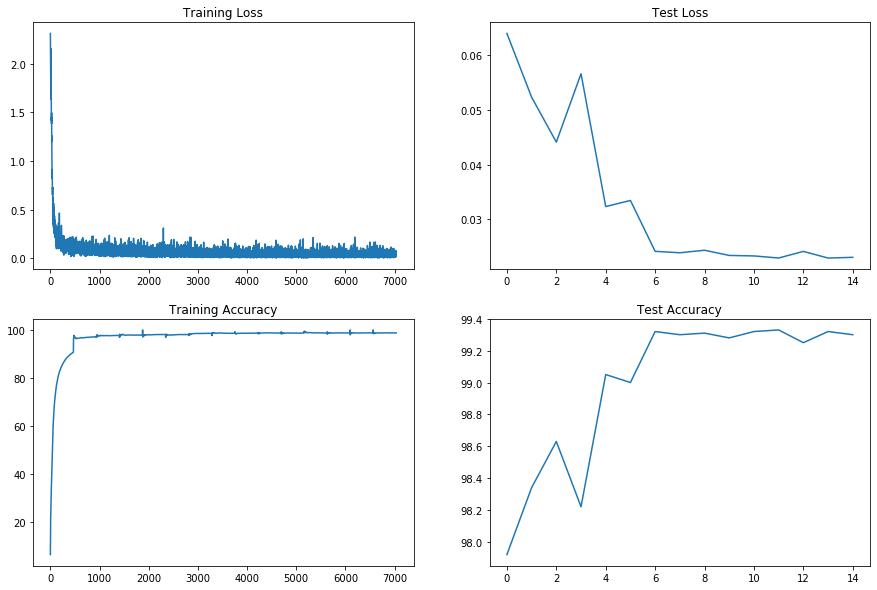

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Analysis

Used GAP instead of 1x1 which reduces the model size and hypertuned SGD lr to 0.1, hence resulting in a very optimised and smooth model